# Система автоматизированного выбора и настройки алгоритма классификации задачи кредитного скоринга

## Загрузка и анализ данных

### Загрузка библиотек, датасета для кредитного скоринга

Библиотеки:
* pandas
* sklearn
* kagglehub
* matplotlib
* seaborn
* tpot
* h20

In [98]:
import warnings
warnings.filterwarnings("ignore")

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import utils
from sklearn.metrics import(
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
#matplotlib inline

In [100]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kornilovag94/bank-credit-default-loan-default")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\AntMur00\.cache\kagglehub\datasets\kornilovag94\bank-credit-default-loan-default\versions\2


In [101]:
data = pd.read_parquet(path+'/data/train_data/train_data_0.pq')

In [102]:
dataset_count=len(data)
print(f"Количество записей в первом файле датасета: {dataset_count}")

Количество записей в первом файле датасета: 1974724


In [103]:
import os
i = 1
while os.path.isfile(path+f'/data/train_data/train_data_{i}.pq'):
    temp_path = path+f'/data/train_data/train_data_{i}.pq'
    data_temp = len(pd.read_parquet(temp_path))
    dataset_count += data_temp
    i+=1
print(f"Общее количество записей в датасете: {dataset_count}")

Общее количество записей в датасете: 26162717


In [104]:
pd.set_option('display.max_columns', None)
data.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,5,0,2,8,6,16,5,4,8,1,1,1,1,1,15,2,17,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,3,0,2,4,6,16,5,4,8,0,1,1,1,1,16,2,17,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,3,0,2,4,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0


In [105]:
pd.reset_option('display.max_columns')

### Признаки


* id - идентификатор заявки;
* rn - порядковый номер кредитного продукта в кредитной истории;
* pre_since_opened - дни с даты открытия кредита до даты сбора данных;
* pre_since_confirmed - дни с даты подтверждения кредитной информации до даты сбора данных;
* pre_pterm - планируемое количество дней с даты открытия кредита до даты закрытия;
* pre_fterm - фактическое количество дней. с даты открытия кредита до даты закрытия;
* pre_till_pclose - планируемое количество дней с даты сбора данных до даты закрытия кредита;
* pre_till_fclose - фактическое количество дней с даты сбора данных до даты закрытия кредита;
* pre_loans_credit_limit - кредитный лимит;
* pre_loans_next_pay_summ - сумма следующего платежа по кредиту;
* pre_loans_outstanding - сумма непогашенного кредита;
* pre_loans_total_overdue - текущая сумма просрочки;
* pre_loans_max_overdue_sum - максимальная сумма просрочки;
* pre_loans_credit_cost_rate - общая стоимость кредита;
* pre_loans5 - количество просрочка до 5 дней;
* pre_loans530 - номер количество просрочек от 5 до 30 дней;
* pre_loans3060 - количество просрочек от 30 до 60 дней;
* pre_loans6090 - количество просрочек от 60 до 90 дней;
* pre_loans90 - количество просрочек более 90 дней;
* is_zero_loans_5 - флаг: нет просрочек до 5 дней;
* is_zero_loans_530 - флаг: нет просрочек от 5 до 30 дней;
* is_zero_loans_3060 - флаг: нет просрочек от 30 до 60 дней;
* is_zero_loans_6090 - флаг: нет правонарушения в области от 60 до 90 дней;
* is_zero_loans90 - флаг: просрочки не превышают 90 дней;
* pre_util - отношение суммы непогашенного кредита к кредитному лимиту;
* pre_over2limit - отношение текущей просроченной задолженности к кредитному лимиту;
* pre_maxover2limit - отношение максимальной просроченной задолженности к кредитному лимиту;
* is_zero_util - флаг: отношение суммы непогашенного кредита к кредитному лимиту равно 0;
* is_zero_over2limit - флаг: отношение текущей просроченной задолженности к кредитному лимиту равно 0;
* is_zero_maxover2limit - флаг: отношение максимальной просроченной задолженности к кредитному лимиту равно 0;
* enc_paym_{0...n} - ежемесячно статусы платежей за последние n месяцев;
* enc_loans_account_holder_type - тип отношения к кредиту;
* enc_loans_credit_status - статус кредита;
* enc_loans_account_cur - валюта кредита;
* enc_loans_credit_type - тип кредита; 
* pclose_flag - флаг: планируемое количество дней с даты открытия до даты закрытия кредита;
* fclose_flag - флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено.

In [106]:
data.shape

(1974724, 61)

## Предобработка данных

In [107]:
data.drop(columns=['pre_loans_total_overdue','pre_loans_max_overdue_sum','rn','pre_loans_outstanding','enc_paym_0','enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5',
       'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10',
       'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14',
       'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18',
       'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22',
       'enc_paym_23', 'enc_paym_24','is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90','enc_loans_account_cur'], inplace=True)

In [108]:
data.dtypes

id                               int64
pre_since_opened                 int64
pre_since_confirmed              int64
pre_pterm                        int64
pre_fterm                        int64
pre_till_pclose                  int64
pre_till_fclose                  int64
pre_loans_credit_limit           int64
pre_loans_next_pay_summ          int64
pre_loans_credit_cost_rate       int64
pre_loans5                       int64
pre_loans530                     int64
pre_loans3060                    int64
pre_loans6090                    int64
pre_loans90                      int64
pre_util                         int64
pre_over2limit                   int64
pre_maxover2limit                int64
is_zero_util                     int64
is_zero_over2limit               int64
is_zero_maxover2limit            int64
enc_loans_account_holder_type    int64
enc_loans_credit_status          int64
enc_loans_credit_type            int64
pclose_flag                      int64
fclose_flag              

In [109]:
data_2 = pd.read_csv(path+'/target.csv')

In [110]:
data_2 = data_2.iloc[:250000]
data_2.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [111]:
data_2.shape

(250000, 2)

In [112]:
merged_data = pd.merge(data, data_2 , on = 'id')
merged_data.shape

(1974724, 27)

In [113]:
merged_data.drop(columns=['id'], inplace=True)

In [114]:
merged_data.head()

,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_credit_cost_rate,pre_loans5,...,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,pclose_flag,fclose_flag,flag
0,18,9,2,3,16,10,11,3,11,6,...,17,1,1,1,1,3,4,0,0,0
1,18,9,14,14,12,12,0,3,11,6,...,17,1,1,1,1,3,4,0,0,0
2,18,9,4,8,1,11,11,0,8,6,...,17,0,1,1,1,2,3,1,1,0
3,4,1,9,12,16,7,12,2,4,6,...,17,1,1,1,1,3,1,0,0,0
4,5,12,15,2,11,12,10,2,4,6,...,17,1,1,1,1,3,4,0,0,0


In [115]:
merged_data['flag'] = merged_data['pre_since_opened'].apply(lambda x: 1 if x > 10 else 0)

In [116]:
merged_data.isna().sum()

pre_since_opened                 0
pre_since_confirmed              0
pre_pterm                        0
pre_fterm                        0
pre_till_pclose                  0
pre_till_fclose                  0
pre_loans_credit_limit           0
pre_loans_next_pay_summ          0
pre_loans_credit_cost_rate       0
pre_loans5                       0
pre_loans530                     0
pre_loans3060                    0
pre_loans6090                    0
pre_loans90                      0
pre_util                         0
pre_over2limit                   0
pre_maxover2limit                0
is_zero_util                     0
is_zero_over2limit               0
is_zero_maxover2limit            0
enc_loans_account_holder_type    0
enc_loans_credit_status          0
enc_loans_credit_type            0
pclose_flag                      0
fclose_flag                      0
flag                             0
dtype: int64

In [117]:
flag_counts = merged_data['flag'].value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = merged_data['flag'].value_counts('0')
print("Соотношение значений в столбце 'flag':")
print(flag_counts)

Количество значений в столбце 'flag':
flag
0    1154627
1     820097
Name: count, dtype: int64

Соотношение значений в столбце 'flag':
flag
0    0.584703
1    0.415297
Name: proportion, dtype: float64


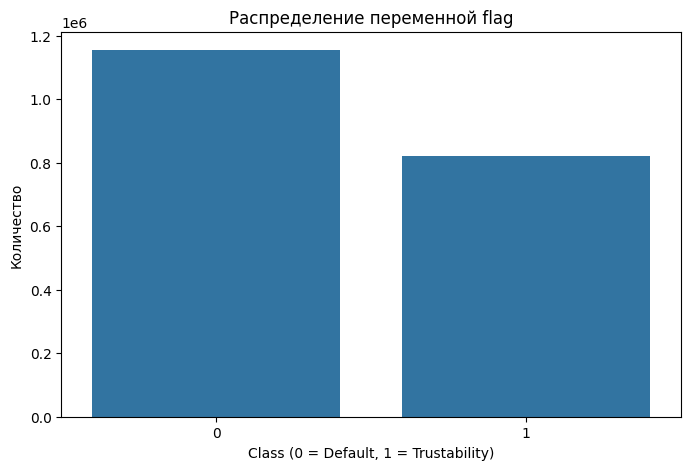

In [118]:
plt.figure(figsize=(8, 5))
sns.countplot(x="flag", data=merged_data)
plt.title("Распределение переменной flag")
plt.xlabel("Class (0 = Default, 1 = Trustability)")
plt.ylabel("Количество")
plt.show()

In [119]:
def corr_matrix(corr):
    plt.figure(figsize=(15,15))

    sns.heatmap(corr, annot=True)

    plt.title('Корреляция признаков')
    plt.show()

    corr_df = pd.DataFrame(corr)
    correlation_matrix = corr_df.corr()

    correlation_threshold = 0.9
    highly_correlated_columns = []

    for column in correlation_matrix:
        correlated_columns = correlation_matrix[column][correlation_matrix[column] > correlation_threshold].index.tolist()
        highly_correlated_columns.extend([(column, correlated_column, correlation_matrix[column][correlated_column]) for correlated_column in correlated_columns])
    # Print the highly correlated column pairs
    for pair in highly_correlated_columns:
        if not pair[0]==pair[1]:
            print(f"Columns '{pair[0]}' and '{pair[1]}' are highly correlated: {pair[2]:.3f}")

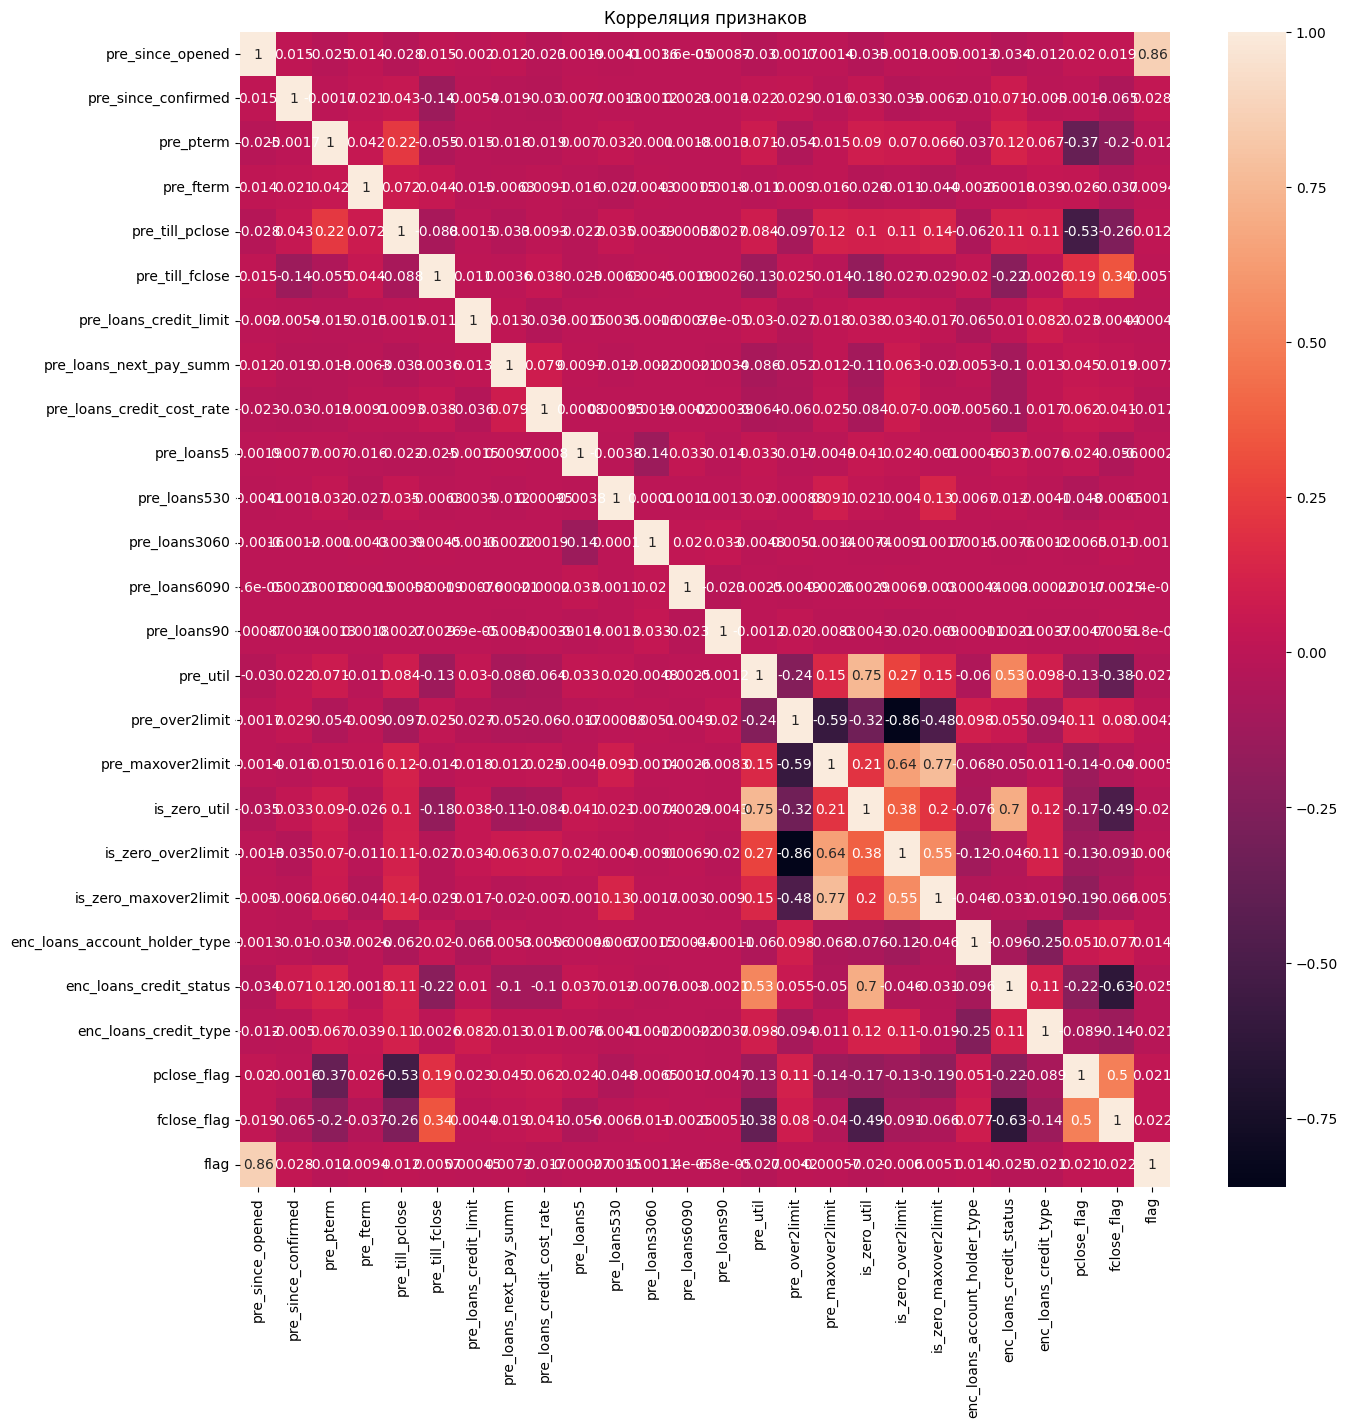

Columns 'pre_since_opened' and 'flag' are highly correlated: 0.988
Columns 'pre_util' and 'is_zero_util' are highly correlated: 0.962
Columns 'pre_maxover2limit' and 'is_zero_over2limit' are highly correlated: 0.910
Columns 'pre_maxover2limit' and 'is_zero_maxover2limit' are highly correlated: 0.968
Columns 'is_zero_util' and 'pre_util' are highly correlated: 0.962
Columns 'is_zero_over2limit' and 'pre_maxover2limit' are highly correlated: 0.910
Columns 'is_zero_maxover2limit' and 'pre_maxover2limit' are highly correlated: 0.968
Columns 'flag' and 'pre_since_opened' are highly correlated: 0.988


In [120]:
corr_matrix(merged_data.corr())

In [121]:
def drop_highly_correlated(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)

In [122]:
data_filtered = drop_highly_correlated(merged_data)

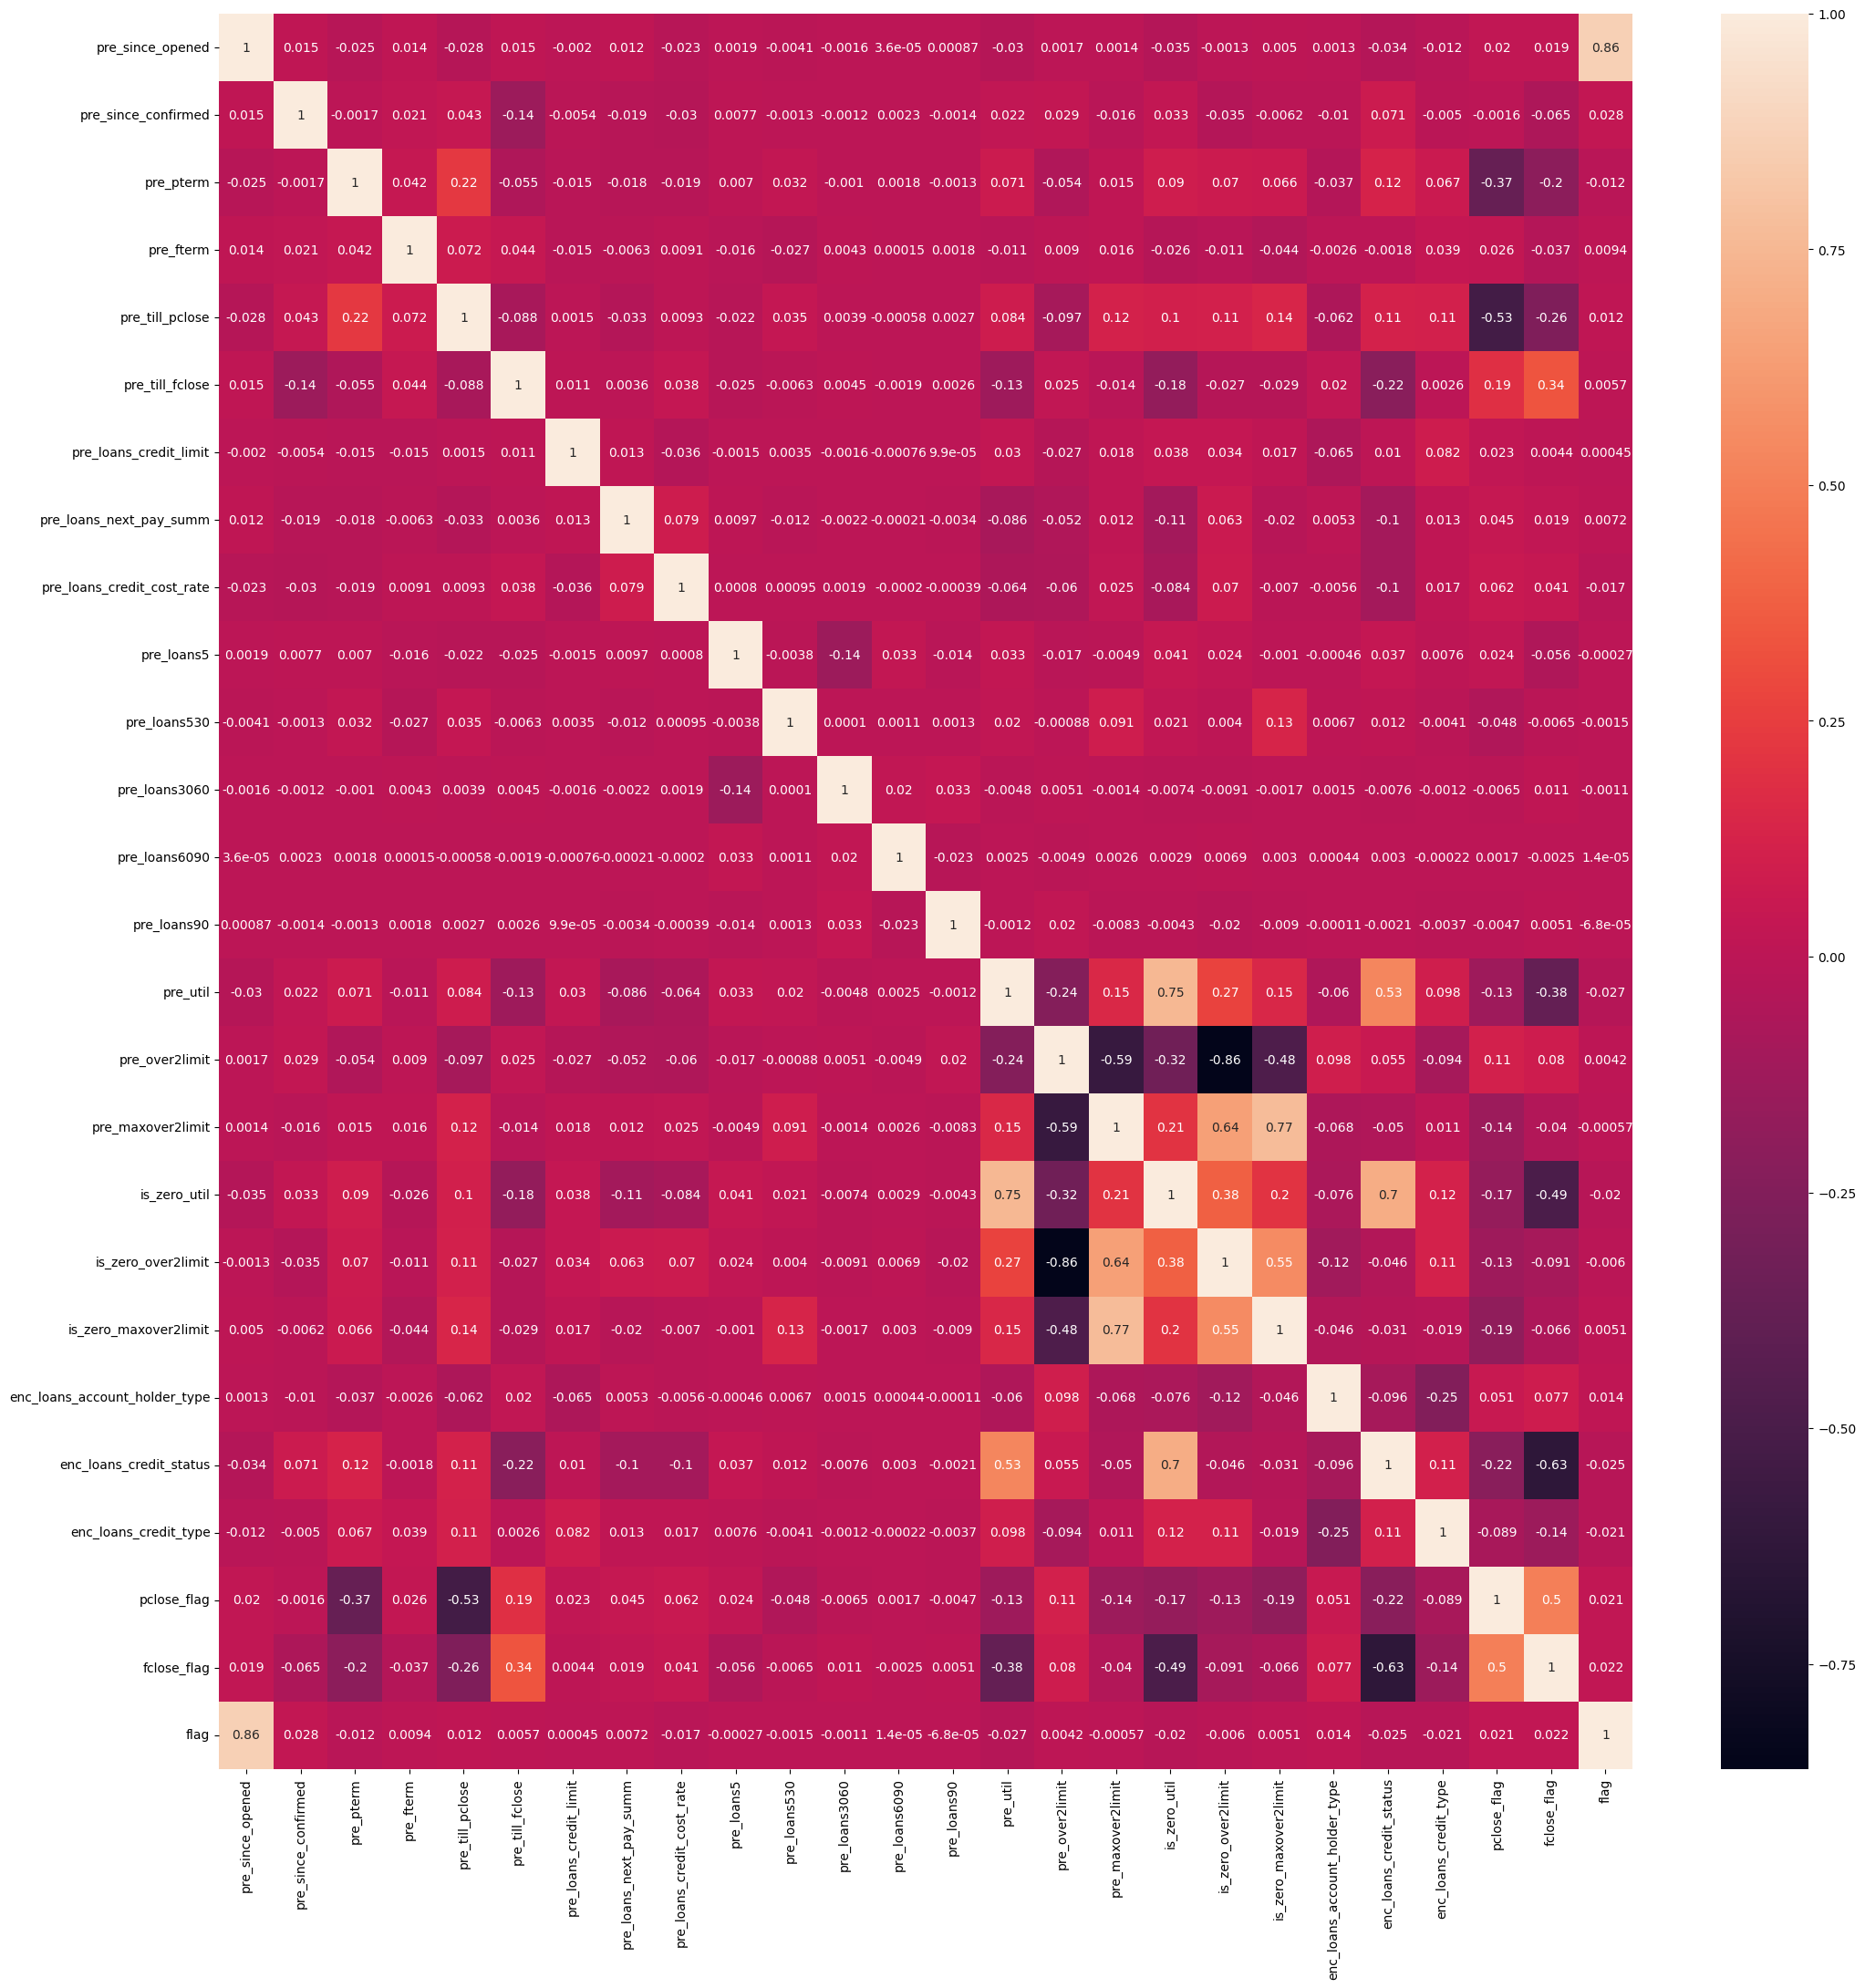

In [123]:
fig, ax = plt.subplots(figsize = (25, 25))
sns.heatmap(data_filtered.corr(), annot=True);

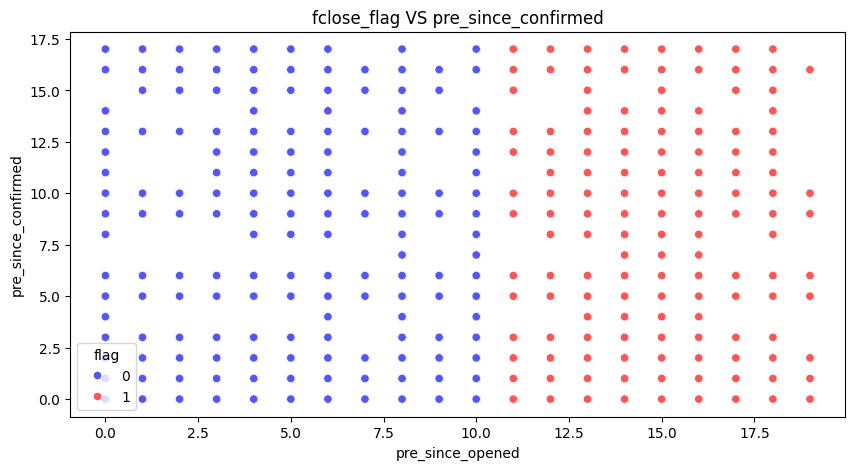

In [124]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=data_filtered, #датасет
    x='pre_since_opened', #ось абсцисс
    y='pre_since_confirmed', #ось ординат
    hue='flag', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('fclose_flag VS pre_since_confirmed');

In [125]:
data_filtered.head()

,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_credit_cost_rate,pre_loans5,...,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,pclose_flag,fclose_flag,flag
0,18,9,2,3,16,10,11,3,11,6,...,17,1,1,1,1,3,4,0,0,1
1,18,9,14,14,12,12,0,3,11,6,...,17,1,1,1,1,3,4,0,0,1
2,18,9,4,8,1,11,11,0,8,6,...,17,0,1,1,1,2,3,1,1,1
3,4,1,9,12,16,7,12,2,4,6,...,17,1,1,1,1,3,1,0,0,0
4,5,12,15,2,11,12,10,2,4,6,...,17,1,1,1,1,3,4,0,0,0


In [126]:
#уменьшение выборки для демонстрации работы TPOT и H2O
test_data = data_filtered[100000:102500]
train_data = data_filtered[:10000]

In [127]:
flag_counts = test_data['flag'].value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = test_data['flag'].value_counts('0')
print("Соотношение значений в столбце 'flag':")
print(flag_counts)

Количество значений в столбце 'flag':
flag
0    1453
1    1047
Name: count, dtype: int64

Соотношение значений в столбце 'flag':
flag
0    0.5812
1    0.4188
Name: proportion, dtype: float64


In [128]:
flag_counts = train_data['flag'].value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = train_data['flag'].value_counts('0')
print("Соотношение значений в столбце 'flag':")
print(flag_counts)

Количество значений в столбце 'flag':
flag
0    5923
1    4077
Name: count, dtype: int64

Соотношение значений в столбце 'flag':
flag
0    0.5923
1    0.4077
Name: proportion, dtype: float64


In [129]:
def x_y_split(df):
    X = df.drop('flag', axis=1)
    y = df['flag']
    return X, y

In [130]:
X, y = x_y_split(train_data)

In [131]:
X_test, y_test = x_y_split(test_data)

In [132]:
def data_scaling(X):
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    X = sc.fit_transform(X)
    return X

In [133]:
scaled_X = pd.DataFrame(data_scaling(X))
scaled_X

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.947368,0.529412,0.117647,0.1875,1.0000,0.666667,0.578947,0.500000,0.846154,1.0,...,0.117647,0.894737,1.0,1.0,1.0,0.0,0.500000,0.8,0.0,0.0
1,0.947368,0.529412,0.823529,0.8750,0.7500,0.800000,0.000000,0.500000,0.846154,1.0,...,0.117647,0.894737,1.0,1.0,1.0,0.0,0.500000,0.8,0.0,0.0
2,0.947368,0.529412,0.235294,0.5000,0.0625,0.733333,0.578947,0.000000,0.615385,1.0,...,0.117647,0.894737,0.0,1.0,1.0,0.0,0.333333,0.6,1.0,1.0
3,0.210526,0.058824,0.529412,0.7500,1.0000,0.466667,0.631579,0.333333,0.307692,1.0,...,0.117647,0.894737,1.0,1.0,1.0,0.0,0.500000,0.2,0.0,0.0
4,0.263158,0.705882,0.882353,0.1250,0.6875,0.800000,0.526316,0.333333,0.307692,1.0,...,0.117647,0.894737,1.0,1.0,1.0,0.0,0.500000,0.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.947368,0.470588,0.823529,0.4375,0.7500,0.733333,0.789474,0.000000,0.153846,1.0,...,0.117647,0.894737,0.0,1.0,1.0,0.4,0.666667,0.0,0.0,0.0
9996,0.210526,1.000000,0.176471,0.3750,0.3125,0.466667,0.947368,0.333333,0.153846,1.0,...,0.117647,0.894737,1.0,1.0,1.0,0.0,0.500000,0.8,0.0,0.0
9997,0.210526,0.352941,0.235294,0.5000,0.0625,0.733333,0.684211,1.000000,0.076923,1.0,...,0.117647,0.157895,0.0,1.0,0.0,0.0,0.333333,0.6,1.0,1.0
9998,0.578947,0.764706,0.529412,0.0000,0.9375,0.933333,0.157895,0.333333,0.076923,1.0,...,0.117647,0.894737,1.0,1.0,1.0,0.0,0.500000,0.8,0.0,0.0


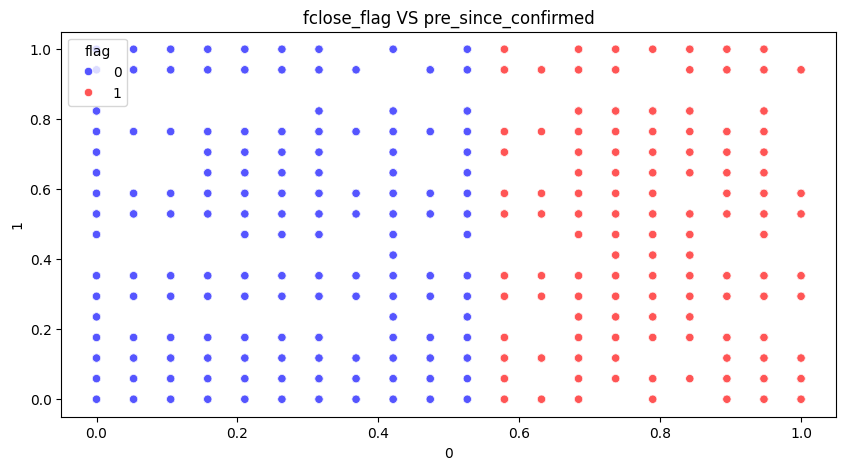

In [134]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=scaled_X, #датасет
    x=0, #ось абсцисс
    y=1, #ось ординат
    hue=y, #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('fclose_flag VS pre_since_confirmed');

In [135]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение TPOT

### Функции метрик

In [136]:
def tpot_prediction(test_data, model):
    y_pred = model.predict(test_data)
    y_proba = model.predict_proba(test_data)[:, 1]
    return y_pred, y_proba

In [137]:
def metrics(y_test, y_pred, y_proba):
    # Вычисление метрик
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC_AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print()
    # Матрица ошибок
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # Полный отчет
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

### Процесс обучения

In [138]:
#%pip install tpot

In [139]:
from sklearn import utils
from tpot import TPOTClassifier
import tpot

In [140]:
tpot_generations = [5, 10]
tpot_popsize = [50, 100]
tpot_models = []

In [141]:
# проводим обучение нескольких моделей tpot
for gen_param in tpot_generations:
    for pop_param in tpot_popsize:
        tpot = TPOTClassifier(
            generations=gen_param,
            population_size=pop_param,
            random_state=42,
            cv=5,
            #n_jobs=-1,
            scorers='recall',
        )
        tpot.fit(X_train, y_train)
        tpot_models.append(tpot)

Generation:  50%|█████     | 5/10 [1:00:00<1:00:00, 720.13s/it]


In [143]:
# Оценка модели на валидационных данных
for tpot in tpot_models:
    print(f'{tpot_models.index(tpot)} tpot model: generations={tpot.generations}, pop_size={tpot.population_size}')
    y_pred, y_proba = tpot_prediction(X_val, tpot)
    metrics(y_val, y_pred, y_proba)

    print('\nBest pipeline steps:', end='\n')
    for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
        print(f'{idx}. {transform}')
    
    test_predictions, test_probablity = tpot_prediction(X_test, tpot)
    metrics(y_test, test_predictions, test_probablity)
    
    if not (tpot_models.index(tpot) == len(tpot_models)-1):
        print('\n'+('-='*20)+'-\n')

0 tpot model: generations=5, pop_size=50
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC_AUC: 1.0000

Confusion Matrix:
 [[1764    0]
 [   0 1236]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1764
           1       1.00      1.00      1.00      1236

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000


Best pipeline steps:
1. MinMaxScaler()
2. RFE(estimator=ExtraTreesClassifier(max_features=0.4503212524738,
                                   min_samples_leaf=4, min_samples_split=7,
                                   n_jobs=1, random_state=42),
    step=0.9162776237062)
3. FeatureUnion(transformer_list=[('featureunion',
                                FeatureUnion(transformer_list=[('binarizer',
                                                                Binarizer(th

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC_AUC: 1.0000

Confusion Matrix:
 [[913   0]
 [  0 587]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       913
           1       1.00      1.00      1.00       587

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



In [156]:
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    print(f'{idx}. {transform}')


Best pipeline steps:
1. MinMaxScaler()
2. RFE(estimator=ExtraTreesClassifier(max_features=0.4503212524738,
                                   min_samples_leaf=4, min_samples_split=7,
                                   n_jobs=1, random_state=42),
    step=0.9162776237062)
3. FeatureUnion(transformer_list=[('featureunion',
                                FeatureUnion(transformer_list=[('binarizer',
                                                                Binarizer(threshold=0.856281565145)),
                                                               ('pca',
                                                                PCA(n_components=0.5132293634216))])),
                               ('passthrough', Passthrough())])
4. FeatureUnion(transformer_list=[('skiptransformer', SkipTransformer()),
                               ('passthrough', Passthrough())])
5. XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=No

In [153]:
# Экспорт лучшего пайплайна в виде Python-кода
tpot.export('tpot_pipeline.py')

AttributeError: 'TPOTClassifier' object has no attribute 'export'

In [147]:
# Предсказание на тестовых данных
test_predictions, test_probablity = tpot_prediction(X_test)

In [148]:
metrics(y_test, test_predictions, test_probablity)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC_AUC: 1.0000

Confusion Matrix:
 [[152   0]
 [  0  98]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       152
           1       1.00      1.00      1.00        98

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



## Обучение H2O

In [ ]:
%pip install h2o

In [2]:
import h2o
from h2o.automl import H2OAutoML

In [5]:
# Ячейка 2: Инициализация H2O и загрузка данных
h2o.init(nthreads=-1, max_mem_size="4G", ip="127.0.0.1", port='54321')

Checking whether there is an H2O instance running at http://127.0.0.1:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.451-b10, mixed mode)
  Starting server from C:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\AntMur00\AppData\Local\Temp\tmpkh0g5ib8
  JVM stdout: C:\Users\AntMur00\AppData\Local\Temp\tmpkh0g5ib8\h2o_AntMur00_started_from_python.out
  JVM stderr: C:\Users\AntMur00\AppData\Local\Temp\tmpkh0g5ib8\h2o_AntMur00_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Yekaterinburg
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_AntMur00_00gi4c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [ ]:
h2o_train_df, h2o_val_df = train_test_split(train_data, test_size=0.3, random_state=42)

In [ ]:
h2o_train_df.shape

In [ ]:
h2o_val_df.shape

In [ ]:
h2o_train_df['flag'] = h2o_train_df['flag'].apply(lambda x: "yes" if x == 1 else "no")
h2o_val_df['flag'] = h2o_val_df['flag'].apply(lambda x: "yes" if x == 1 else "no")
test_data['flag'] = test_data['flag'].apply(lambda x: "yes" if x == 1 else "no")

In [ ]:
# Преобразование в H2O фреймы
train_h2o = h2o.H2OFrame(h2o_train_df)
val_h2o = h2o.H2OFrame(h2o_val_df)
test_h2o = h2o.H2OFrame(test_data)

In [ ]:
# Определение целевой переменной и признаков
target = 'flag'
features = list(train_data.columns)

In [ ]:
train_h2o

In [ ]:
# Запуск H2O AutoML
aml = H2OAutoML(max_models=4, max_runtime_secs=3600, seed=42, verbosity='info', nfolds=5)
aml.train(x=features, y=target, training_frame=train_h2o, validation_frame=val_h2o)

In [ ]:
# Вывод Leaderboard
print("\nLeaderboard:")
print(aml.leaderboard)

In [ ]:
# Получение лучшей модели
best_model = aml.get_best_model()

In [ ]:
# Оценка лучшей модели на валидационных данных
performance = best_model.model_performance(val_h2o)
print("\nModel Performance on Validation Set:")
print(performance)

In [422]:
print(best_model)

NameError: name 'best_model' is not defined

In [ ]:
# Предсказание на тестовых данных
predictions = aml.predict(test_h2o)
predictions_df = predictions.as_data_frame()
print(predictions)

In [420]:
model_path = h2o.save_model(model=best_model, path="/content/h2o_models", force=True)
print(f"Model saved to: {model_path}")

NameError: name 'best_model' is not defined

In [ ]:
h2o.shutdown()